# LIBRARIES

In [459]:
import yfinance as yf
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import statistics

# GETTING THE DATA

In [460]:
# Download historical data for the given ticker
def historical_data(ticker):
    stock_data = yf.download(ticker, period='max')
    return stock_data

# Example usage
ticker = input("Enter stock ticker: ")
data = historical_data(ticker)

Enter stock ticker: VALE3.SA
[*********************100%***********************]  1 of 1 completed


# PREPARATION

In [461]:
data_prep = data

# Create a pct change column
data_prep['Pct Change'] = data_prep['Adj Close'].pct_change() * 100
    
# Fill NA with the 8 period rolling mean
data_prep = data_prep.fillna(data_prep.rolling(8).mean())
    
# Adding features: Vol, RSI, BB, EMAs
data_prep['Volatility'] = data_prep['Pct Change'].rolling(window=252).std() * 100

windowRSI = 14
delta = data_prep['Adj Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
average_gain = gain.rolling(windowRSI).mean()
average_loss = loss.rolling(windowRSI).mean()
relative_strength = average_gain / average_loss
rsi = 100 - (100 / (1 + relative_strength))   
data_prep['RSI'] = rsi
    
    
windowBB = 20
data_prep['SMA'] = data_prep['Adj Close'].rolling(windowBB).mean()
data_prep['Std'] = data_prep['Adj Close'].rolling(windowBB).std()
data_prep['Upper Band'] = data_prep['SMA'] + (2 * data_prep['Std'])
data_prep['Lower Band'] = data_prep['SMA'] - (2 * data_prep['Std'])
    
    
periods = 8
data_prep['EMA8'] = data_prep['Adj Close'].ewm(span=periods, adjust=False).mean()
    
data_prep["SMA_50"] = data_prep["Adj Close"].rolling(window=50).mean()
data_prep["SMA_200"] = data_prep["Adj Close"].rolling(window=200).mean()
    


data_prep['Predicted'] = "No"
    
# Drop remaining NAs
data_prep =data_prep.dropna()
    
# Rounding data to max 2 decimals
data_prep =round(data_prep,2)

# ESTABLISHING TREND

In [462]:
data_prep['Trend'] = data_prep['SMA_50'] > data_prep['SMA_200']
data_prep['Trend'] = data_prep['Trend'].map({True: 'Uptrend', False: 'Downtrend'})
data_prep=data_prep.reset_index()
data_prep

,Date,Open,High,Low,Close,Adj Close,Volume,Pct Change,Volatility,RSI,SMA,Std,Upper Band,Lower Band,EMA8,SMA_50,SMA_200,Predicted,Trend
0,2000-12-20,3.58,3.58,3.58,3.58,1.70,398400,-2.27,248.85,77.27,1.65,0.10,1.85,1.45,1.72,1.64,1.68,No,Downtrend
1,2000-12-21,3.58,3.59,3.58,3.58,1.70,614400,0.00,248.38,72.22,1.65,0.10,1.85,1.45,1.71,1.64,1.68,No,Downtrend
2,2000-12-22,3.58,3.67,3.58,3.67,1.74,364800,2.33,248.80,72.22,1.66,0.10,1.86,1.46,1.72,1.65,1.68,No,Downtrend
3,2000-12-25,3.67,3.67,3.67,3.67,1.74,0,0.00,248.80,64.29,1.67,0.10,1.87,1.48,1.73,1.65,1.69,No,Downtrend
4,2000-12-26,3.75,3.75,3.67,3.67,1.74,312000,0.00,247.75,61.54,1.68,0.09,1.86,1.50,1.73,1.65,1.69,No,Downtrend
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5635,2023-06-12,67.80,67.80,66.70,67.12,67.12,26651200,-1.81,221.90,46.68,67.14,1.85,70.84,63.44,67.31,71.62,77.16,No,Downtrend
5636,2023-06-13,68.30,68.57,67.61,67.83,67.83,34288100,1.06,220.98,54.55,67.08,1.80,70.68,63.48,67.43,71.37,77.18,No,Downtrend
5637,2023-06-14,68.99,69.61,68.49,69.02,69.02,53775600,1.75,220.26,64.56,67.15,1.85,70.85,63.45,67.78,71.11,77.18,No,Downtrend
5638,2023-06-15,69.10,69.65,68.36,69.56,69.56,31874100,0.78,220.32,66.86,67.13,1.83,70.79,63.48,68.18,70.90,77.20,No,Downtrend


In [463]:
target_value = 'Downtrend'

# Initialize variables to track intervals
start_index = None
end_index = None
intervals_down = []

# Iterate over the DataFrame and identify intervals
for index, row in data_prep.iterrows():
    if row['Trend'] == target_value:
        if start_index is None:
            start_index = index
        end_index = index
    elif start_index is not None:
        intervals_down.append((start_index, end_index))
        start_index = None
        end_index = None

# Handle the case when the last interval continues until the end of the DataFrame
if start_index is not None:
    intervals_down.append((start_index, end_index))
    
sum_i_down=0

for i in intervals_down:
    x=i[1]-i[0]
    sum_i_down=sum_i_down+x
sum_i_down

2157

In [464]:
target_value = 'Uptrend'

# Initialize variables to track intervals
start_index = None
end_index = None
intervals_up = []

# Iterate over the DataFrame and identify intervals
for index, row in data_prep.iterrows():
    if row['Trend'] == target_value:
        if start_index is None:
            start_index = index
        end_index = index
    elif start_index is not None:
        intervals_up.append((start_index, end_index))
        start_index = None
        end_index = None

# Handle the case when the last interval continues until the end of the DataFrame
if start_index is not None:
    intervals_up.append((start_index, end_index))

sum_i_up=0

for i in intervals_up:
    x=i[1]-i[0]
    sum_i_up=sum_i_up+x
sum_i_up

3452

In [465]:
trend_ratio=sum_i_up/sum_i_down
trend_ratio

1.6003708854891052

In [466]:
i_down=[]
i_down2=[]

for i in intervals_down:
    for j in i:
        y = data_prep['Adj Close'][j]        
        i_down2.append(y)    
    i_down.append(i_down2)
    i_down2=[]
d_trend_adj = pd.DataFrame(i_down)

In [467]:
i_up=[]
i_up2=[]

for i in intervals_up:
    for j in i:
        y = data_prep['Adj Close'][j]        
        i_up2.append(y)    
    i_up.append(i_up2)
    i_up2=[]
up_trend_adj = pd.DataFrame(i_up)

In [468]:
d_trend = pd.DataFrame(intervals_down)
d_trend['lenght'] = d_trend[1] - d_trend[0]

In [469]:
up_trend = pd.DataFrame(intervals_up)
up_trend['lenght'] = up_trend[1] - up_trend[0]

In [470]:
dfs_down={}
dfs_down_total = pd.DataFrame()
for i, interval in enumerate(intervals_down):
    x = intervals_down[i][0]
    y = intervals_down[i][1]
    dfs_down = data_prep.iloc[x:y+1]
    new_row = {'Pct Change':1000}
    dfs_down.loc[len(dfs_down)] = new_row
    dfs_down_total = pd.concat([dfs_down_total, dfs_down])

dfs_up={}
dfs_up_total = pd.DataFrame()
for i, interval in enumerate(intervals_up):
    x = intervals_up[i][0]
    y = intervals_up[i][1]
    dfs_up = data_prep.iloc[x:y+1]
    new_row = {'Pct Change':1000}
    dfs_up.loc[len(dfs_up)] = new_row
    dfs_up_total = pd.concat([dfs_up_total, dfs_up])

C:\Users\bviei\anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
C:\Users\bviei\anaconda3\lib\site-packages\pandas\core\indexing.py:1797: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, v, pi)


In [471]:
dfs_down_total

,Date,Open,High,Low,Close,Adj Close,Volume,Pct Change,Volatility,RSI,SMA,Std,Upper Band,Lower Band,EMA8,SMA_50,SMA_200,Predicted,Trend
0,2000-12-20,3.58,3.58,3.58,3.58,1.70,398400.0,-2.27,248.85,77.27,1.65,0.10,1.85,1.45,1.72,1.64,1.68,No,Downtrend
1,2000-12-21,3.58,3.59,3.58,3.58,1.70,614400.0,0.00,248.38,72.22,1.65,0.10,1.85,1.45,1.71,1.64,1.68,No,Downtrend
2,2000-12-22,3.58,3.67,3.58,3.67,1.74,364800.0,2.33,248.80,72.22,1.66,0.10,1.86,1.46,1.72,1.65,1.68,No,Downtrend
3,2000-12-25,3.67,3.67,3.67,3.67,1.74,0.0,0.00,248.80,64.29,1.67,0.10,1.87,1.48,1.73,1.65,1.69,No,Downtrend
4,2000-12-26,3.75,3.75,3.67,3.67,1.74,312000.0,0.00,247.75,61.54,1.68,0.09,1.86,1.50,1.73,1.65,1.69,No,Downtrend
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5636,2023-06-13,68.30,68.57,67.61,67.83,67.83,34288100.0,1.06,220.98,54.55,67.08,1.80,70.68,63.48,67.43,71.37,77.18,No,Downtrend
5637,2023-06-14,68.99,69.61,68.49,69.02,69.02,53775600.0,1.75,220.26,64.56,67.15,1.85,70.85,63.45,67.78,71.11,77.18,No,Downtrend
5638,2023-06-15,69.10,69.65,68.36,69.56,69.56,31874100.0,0.78,220.32,66.86,67.13,1.83,70.79,63.48,68.18,70.90,77.20,No,Downtrend
5639,2023-06-16,69.40,70.20,69.21,69.87,69.87,14791600.0,0.45,219.44,63.83,67.13,1.82,70.76,63.49,68.55,70.69,77.21,No,Downtrend


In [472]:
dfs_up_total

,Date,Open,High,Low,Close,Adj Close,Volume,Pct Change,Volatility,RSI,SMA,Std,Upper Band,Lower Band,EMA8,SMA_50,SMA_200,Predicted,Trend
28,2001-01-29,4.10,4.21,4.10,4.21,2.00,307200.0,2.96,244.14,84.21,1.81,0.10,2.00,1.61,1.91,1.73,1.72,No,Uptrend
29,2001-01-30,4.21,4.21,4.08,4.17,1.98,643200.0,-0.99,241.93,80.08,1.82,0.10,2.02,1.62,1.93,1.74,1.72,No,Uptrend
30,2001-01-31,4.16,4.25,4.16,4.25,2.02,854400.0,2.00,242.09,87.80,1.83,0.11,2.05,1.61,1.95,1.75,1.73,No,Uptrend
31,2001-02-01,4.20,4.20,4.17,4.17,1.98,240000.0,-1.96,241.96,81.82,1.84,0.11,2.07,1.61,1.95,1.75,1.73,No,Uptrend
32,2001-02-02,4.12,4.21,4.08,4.12,1.96,729600.0,-1.00,242.05,77.27,1.85,0.12,2.08,1.62,1.96,1.76,1.73,No,Uptrend
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5614,2023-05-11,68.00,68.29,67.36,68.01,68.01,27709000.0,-1.95,222.05,30.10,72.76,4.32,81.39,64.12,69.62,78.21,76.95,No,Uptrend
5615,2023-05-12,67.90,68.57,67.41,68.08,68.08,17578100.0,0.10,221.91,32.85,72.13,4.02,80.16,64.10,69.28,77.91,76.97,No,Uptrend
5616,2023-05-15,69.30,70.13,68.92,69.06,69.06,21020000.0,1.44,220.54,41.70,71.61,3.67,78.95,64.27,69.23,77.54,76.98,No,Uptrend
5617,2023-05-16,69.00,69.20,67.60,67.64,67.64,23990300.0,-2.06,220.83,43.03,71.05,3.35,77.75,64.34,68.88,77.15,77.00,No,Uptrend


# DEFINING TRAIN & TEST SIZES

In [473]:
x= dfs_down_total.index[-2]
y= dfs_up_total.index[-2]

train_percentage = 0.995
if x>y:
    split_index = int(len(dfs_down_total) * train_percentage)
    data_train = dfs_down_total[:split_index]
    data_test = dfs_down_total[split_index:]
else:
    split_index = int(len(dfs_up_total) * train_percentage)
    data_train = dfs_up_total[:split_index]
    data_test = dfs_up_total[split_index:]


size_train = len(data_train)
size_test = len(data_test)

# TRAIN

In [474]:
value_var= 0.05


g0=0
g1=0
g2=0
g3=0
g4=0
g5=0
g6=0
g7=0



final_train=pd.DataFrame()

for i in range(size_train):
    x = data_train.iloc[i]['Pct Change']
    if x ==1000.0:
        None
    else:
        ult_pct = data_train.iloc[i]['Pct Change']
        ult_adj = data_train.iloc[i]['Adj Close']

        ult_pct_up = ult_pct + value_var
        ult_pct_down = ult_pct - value_var

        list_pct = list(data_train['Pct Change'])
        list_pct = [value for value in list_pct if value != 1000]


        list_pct_range = []

        n=0
        for j in list_pct:    
            n=n+1
            if j > ult_pct_down and j < ult_pct_up:
                try:
                    list_pct_range.append(list_pct[n])
                except:
                    None


        target_length = (len(list_pct_range) // 8 + 1) * 8  # Calculate the target length as the next multiple of 8
        median = statistics.median(list_pct_range)
        while len(list_pct_range) < target_length:
            list_pct_range.append(median)
        list_pct_range.sort()

        num_groups = 8

        groups=[]

        group_size = len(list_pct_range) // num_groups  # Calculate the size of each group
        remainder = len(list_pct_range) % num_groups  # Calculate the remainder

        groups = []
        start = 0
        for i in range(num_groups):
            if i < remainder:
                end = start + group_size + 1
            else:
                end = start + group_size
            groups.append(list_pct_range[start:end])
            start = end




        groups_2=[]
        for k, group in enumerate(groups):
            groups_2.append(group)


        mmm_total = []
        for sublist in groups_2:
            median = statistics.median(sublist)
            mean = statistics.mean(sublist)
            mode = statistics.mode(sublist)
            mmm_avg = (median+mean+mode)/3
            mmm_avg=mmm_avg/100
            mmm_total.append(mmm_avg)


        target_number = data_train.iloc[i+1]['Pct Change']
        target_number=target_number/100

        closest_position = min(range(len(mmm_total)), key=lambda i: abs(mmm_total[i] - target_number))


        if closest_position == 0:
            g0=g0+1
        elif closest_position == 1:
            g1=g1+1
        elif closest_position == 2:
            g2=g2+1
        elif closest_position == 3:
            g3=g3+1
        elif closest_position == 4:
            g4=g4+1
        elif closest_position == 5:
            g5=g5+1
        elif closest_position == 6:
            g6=g6+1
        elif closest_position == 7:
            g7=g7+1

        total_g = g0+g1+g2+g3+g4+g5+g6+g7

        total_g0 = g0/total_g
        total_g1 = g1/total_g
        total_g2 = g2/total_g
        total_g3 = g3/total_g
        total_g4 = g4/total_g
        total_g5 = g5/total_g
        total_g6 = g6/total_g
        total_g7 = g7/total_g

        var_total=0
        var_total = mmm_total[0]*total_g0 + mmm_total[1]*total_g1 + mmm_total[2]*total_g2 + mmm_total[3]*total_g3 + mmm_total[4]*total_g4 + mmm_total[5]*total_g5 + mmm_total[6]*total_g6 + mmm_total[7]*total_g7

        first_adj_pred = ult_adj*(1+var_total)

        first_adj_pred=round(first_adj_pred,2)

        var_total= var_total*100
        var_total =round(var_total,2)

        new_row = {'Open':0,'High':0,'Low':0,'Close':0,'Adj Close':first_adj_pred,'Volume':0,'Pct Change':var_total,'Volatility':0,'RSI':0,'SMA':0,'Std':0,'Upper Band':0,'Lower Band':0,'EMA8':0, 'Predicted': "Yes"}

        final_train=final_train.append(new_row, ignore_index=True)

final_train

,Open,High,Low,Close,Adj Close,Volume,Pct Change,Volatility,RSI,SMA,Std,Upper Band,Lower Band,EMA8,Predicted
0,0.0,0.0,0.0,0.0,1.69,0.0,-0.31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Yes
1,0.0,0.0,0.0,0.0,1.70,0.0,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Yes
2,0.0,0.0,0.0,0.0,1.75,0.0,0.34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Yes
3,0.0,0.0,0.0,0.0,1.74,0.0,-0.11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Yes
4,0.0,0.0,0.0,0.0,1.74,0.0,-0.09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2158,0.0,0.0,0.0,0.0,66.53,0.0,0.30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Yes
2159,0.0,0.0,0.0,0.0,66.04,0.0,0.32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Yes
2160,0.0,0.0,0.0,0.0,64.10,0.0,-0.27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Yes
2161,0.0,0.0,0.0,0.0,63.92,0.0,0.18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Yes


In [475]:
print(total_g0,total_g1,total_g2,total_g3,total_g4,total_g5,total_g6,total_g7)

0.042071197411003236 0.05917706888580675 0.17614424410540916 0.2778548312528895 0.22098936662043459 0.15765141007859454 0.04900601017105871 0.017105871474803514


In [476]:
sum((total_g0,total_g1,total_g2,total_g3,total_g4,total_g5,total_g6,total_g7))

0.9999999999999999

In [477]:
final_train=final_train['Adj Close']
final_train=final_train.reset_index(drop=True)
final_train=final_train.rename("Train")

In [478]:
data_train_real=data_train['Adj Close']
data_train_real=data_train_real.reset_index(drop=True)
data_train_real=data_train_real.rename("Real")

<AxesSubplot:>

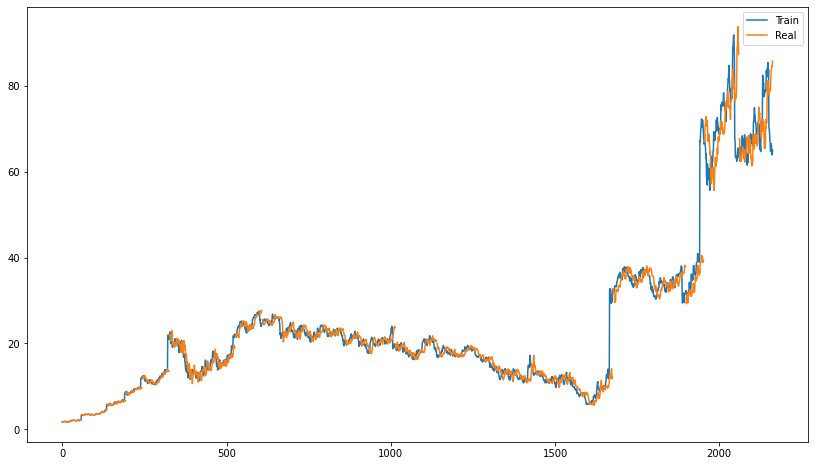

In [479]:
result_train = pd.concat([final_train, data_train_real], axis=1, join="inner")

plt.rcParams['figure.figsize'] = [14, 8]
result_train[["Train","Real"]].plot()

In [480]:
result_train

,Train,Real
0,1.69,1.70
1,1.70,1.70
2,1.75,1.74
3,1.74,1.74
4,1.74,1.74
...,...,...
2158,66.53,83.58
2159,66.04,84.04
2160,64.10,84.65
2161,63.92,84.56


# TEST

In [481]:
value_var= 0.05

final_test=pd.DataFrame()

ult_pct = data_train.iloc[-1]['Pct Change']
ult_adj = data_train.iloc[-1]['Adj Close']


for i in range(size_test):

#    ult_pct = data_train.iloc[-1]['Pct Change']
#    ult_adj = data_train.iloc[-1]['Adj Close']

    ult_pct_up = ult_pct + value_var
    ult_pct_down = ult_pct - value_var
    list_pct = list(data_train['Pct Change'])
    list_pct = [value for value in list_pct if value != 1000]

    list_pct_range = []


    n=0
    for i in list_pct:    
        n=n+1
        if i > ult_pct_down and i < ult_pct_up:
            try:
                list_pct_range.append(list_pct[n])
            except:
                None
                
                
    target_length = (len(list_pct_range) // 8 + 1) * 8  # Calculate the target length as the next multiple of 8
    median = statistics.median(list_pct_range)
    while len(list_pct_range) < target_length:
        list_pct_range.append(median)
    list_pct_range.sort()

    num_groups = 8

    groups=[]

    group_size = len(list_pct_range) // num_groups  # Calculate the size of each group
    remainder = len(list_pct_range) % num_groups  # Calculate the remainder

    groups = []
    start = 0
    for i in range(num_groups):
        if i < remainder:
            end = start + group_size + 1
        else:
            end = start + group_size
        groups.append(list_pct_range[start:end])
        start = end




    groups_2=[]
    for k, group in enumerate(groups):
        groups_2.append(group)


    mmm_total = []
    for sublist in groups_2:
        median = statistics.median(sublist)
        mean = statistics.mean(sublist)
        mode = statistics.mode(sublist)
        mmm_avg = (median+mean+mode)/3
        mmm_avg=mmm_avg/100
        mmm_total.append(mmm_avg)
   
    
    var_total = mmm_total[0]*total_g0 + mmm_total[1]*total_g1 + mmm_total[2]*total_g2 + mmm_total[3]*total_g3 + mmm_total[4]*total_g4 + mmm_total[5]*total_g5 + mmm_total[6]*total_g6 + mmm_total[7]*total_g7

    first_adj_pred = ult_adj*(1+var_total)

    first_adj_pred=round(first_adj_pred,2)

    var_total= var_total*100
    var_total =round(var_total,2)
    
    new_row = {'Open':0,'High':0,'Low':0,'Close':0,'Adj Close':first_adj_pred,'Volume':0,'Pct Change':var_total,'Volatility':0,'RSI':0,'SMA':0,'Std':0,'Upper Band':0,'Lower Band':0,'EMA8':0, 'Predicted': "Yes"}

    final_test=final_test.append(new_row, ignore_index=True)
    
    ult_pct = var_total
    ult_adj = first_adj_pred


final_test

,Open,High,Low,Close,Adj Close,Volume,Pct Change,Volatility,RSI,SMA,Std,Upper Band,Lower Band,EMA8,Predicted
0,0.0,0.0,0.0,0.0,65.05,0.0,-0.17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Yes
1,0.0,0.0,0.0,0.0,65.32,0.0,0.42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Yes
2,0.0,0.0,0.0,0.0,65.04,0.0,-0.42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Yes
3,0.0,0.0,0.0,0.0,64.74,0.0,-0.46,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Yes
4,0.0,0.0,0.0,0.0,64.55,0.0,-0.30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Yes
5,0.0,0.0,0.0,0.0,64.63,0.0,0.12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Yes
6,0.0,0.0,0.0,0.0,64.94,0.0,0.48,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Yes
7,0.0,0.0,0.0,0.0,64.75,0.0,-0.30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Yes
8,0.0,0.0,0.0,0.0,64.83,0.0,0.12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Yes
9,0.0,0.0,0.0,0.0,65.14,0.0,0.48,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Yes


In [482]:
final_test=final_test['Adj Close']
final_test=final_test.reset_index(drop=True)
final_test=final_test.rename("Test")

In [483]:
data_test_real=data_test['Adj Close']
data_test_real=data_test_real.reset_index(drop=True)
data_test_real=data_test_real.rename("Real")

<AxesSubplot:>

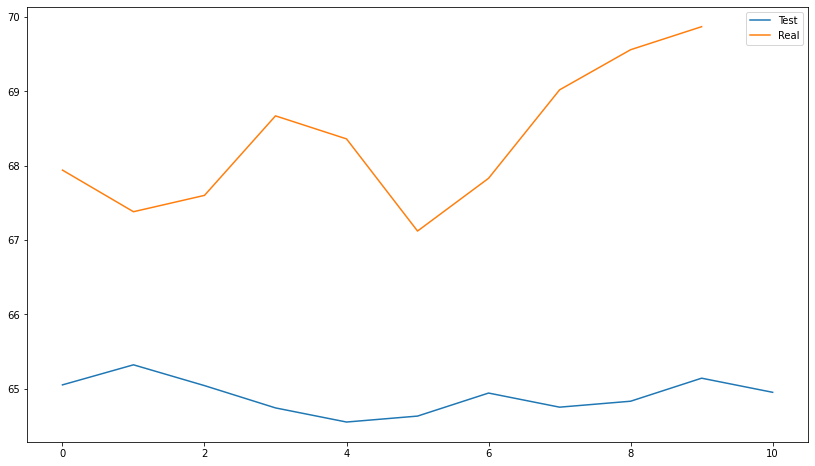

In [484]:
result_test = pd.concat([final_test, data_test_real], axis=1, join="inner")

plt.rcParams['figure.figsize'] = [14, 8]
result_test[["Test","Real"]].plot()

In [485]:
result_test

,Test,Real
0,65.05,67.94
1,65.32,67.38
2,65.04,67.60
3,64.74,68.67
4,64.55,68.36
5,64.63,67.12
6,64.94,67.83
7,64.75,69.02
8,64.83,69.56
9,65.14,69.87


# FORECAST

In [ ]:
days = input('Type the number of days ahead you would like to forecast:')
days=int(days)

In [ ]:
value_var= 0.05

final_test=pd.DataFrame()


ult_pct = data_test.iloc[-2]['Pct Change']
ult_adj = data_test.iloc[-2]['Adj Close']


for i in range(days):

#    ult_pct = data_train.iloc[-1]['Pct Change']
#    ult_adj = data_train.iloc[-1]['Adj Close']

    ult_pct_up = ult_pct + value_var
    ult_pct_down = ult_pct - value_var

    list_pct = list(data_train['Pct Change'])
    list_pct = [value for value in list_pct if value != 1000]

    list_pct_range = []


    n=0
    for i in list_pct:    
        n=n+1
        if i > ult_pct_down and i < ult_pct_up:
            try:
                list_pct_range.append(list_pct[n])
            except:
                None
                
                
    target_length = (len(list_pct_range) // 8 + 1) * 8  # Calculate the target length as the next multiple of 8
    median = statistics.median(list_pct_range)
    while len(list_pct_range) < target_length:
        list_pct_range.append(median)
    list_pct_range.sort()

    num_groups = 8

    groups=[]

    group_size = len(list_pct_range) // num_groups  # Calculate the size of each group
    remainder = len(list_pct_range) % num_groups  # Calculate the remainder

    groups = []
    start = 0
    for i in range(num_groups):
        if i < remainder:
            end = start + group_size + 1
        else:
            end = start + group_size
        groups.append(list_pct_range[start:end])
        start = end




    groups_2=[]
    for k, group in enumerate(groups):
        groups_2.append(group)


    medians = []
    for sublist in groups_2:
        median = statistics.median(sublist)
        mean = statistics.mean(sublist)
        mode = statistics.mode(sublist)
        median = (median+mean+mode)/3
        median=median/100
        medians.append(median)
    
    var_total = medians[0]*total_g0 + medians[1]*total_g1 + medians[2]*total_g2 + medians[3]*total_g3 + medians[4]*total_g4 + medians[5]*total_g5 + medians[6]*total_g6 + medians[7]*total_g7
    
    first_adj_pred = ult_adj*(1+var_total)

    first_adj_pred=round(first_adj_pred,2)

    var_total= var_total*100
    var_total =round(var_total,2)
    
    new_row = {'Open':0,'High':0,'Low':0,'Close':0,'Adj Close':first_adj_pred,'Volume':0,'Pct Change':var_total,'Volatility':0,'RSI':0,'SMA':0,'Std':0,'Upper Band':0,'Lower Band':0,'EMA8':0, 'Predicted': "Yes"}

    final_test=final_test.append(new_row, ignore_index=True)
    
    ult_pct = var_total
    ult_adj = first_adj_pred


final_test

In [ ]:
plt.rcParams['figure.figsize'] = [14, 8]
final_test[["Adj Close"]].plot()